## Work
1. 請比較使用 l1, l2, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Python\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 60us/step - loss: 198.7549 - acc: 0.2342 - val_loss: 41.0714 - val_acc: 0.2423
Epoch 2/50
50000/50000 [==============================] - 2s 48us/step - loss: 19.0651 - acc: 0.1179 - val_loss: 7.2520 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.1013 - acc: 0.0986 - val_loss: 2.6474 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4868 - acc: 0.0956 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0962 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4625 - val

50000/50000 [==============================] - 2s 48us/step - loss: 19.2059 - acc: 0.1208 - val_loss: 7.3362 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.1296 - acc: 0.0994 - val_loss: 2.6508 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4867 - acc: 0.0978 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 48us/step - loss: 4.1169 - acc: 0.0972 - val_loss: 2.6476 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4862 - acc: 0.0976 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0992 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0966 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 46us/step - loss: 2.4855 - acc: 0.0994 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0969 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 48us/step - loss: 10.5347 - acc: 0.4033 - val_loss: 9.8275 - val_acc: 0.4060
Epoch 6/50
50000/50000 [==============================] - 2s 48us/step - loss: 9.1986 - acc: 0.4083 - val_loss: 8.6088 - val_acc: 0.4121
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 8.0603 - acc: 0.4156 - val_loss: 7.5476 - val_acc: 0.4152
Epoch 8/50
50000/50000 [==============================] - 2s 48us/step - loss: 7.0911 - acc: 0.4206 - val_loss: 6.6531 - val_acc: 0.4251
Epoch 9/50
50000/50000 [==============================] - 2s 48us/step - loss: 6.2653 - acc: 0.4223 - val_loss: 5.8894 - val_acc: 0.4271
Epoch 10/50
50000/50000 [==============================] - 2s 48us/step - loss: 5.5623 - acc: 0.4272 - val_loss: 5.2460 - val_acc: 0.4306
Epoch 11/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.9631 - acc: 0.4306 - val_loss: 4.7027 - val_acc: 0.4252
Epoch 12/50
50000/50000 [========================

50000/50000 [==============================] - 2s 47us/step - loss: 5.3458 - acc: 0.4431 - val_loss: 5.3039 - val_acc: 0.4449
Epoch 7/50
50000/50000 [==============================] - 2s 48us/step - loss: 5.2443 - acc: 0.4548 - val_loss: 5.2073 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 2s 48us/step - loss: 5.1475 - acc: 0.4642 - val_loss: 5.1204 - val_acc: 0.4605
Epoch 9/50
50000/50000 [==============================] - 2s 48us/step - loss: 5.0555 - acc: 0.4736 - val_loss: 5.0294 - val_acc: 0.4693
Epoch 10/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.9647 - acc: 0.4833 - val_loss: 4.9560 - val_acc: 0.4714
Epoch 11/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.8783 - acc: 0.4899 - val_loss: 4.8741 - val_acc: 0.4774
Epoch 12/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.7931 - acc: 0.4953 - val_loss: 4.7878 - val_acc: 0.4873
Epoch 13/50
50000/50000 [========================

50000/50000 [==============================] - 2s 48us/step - loss: 5.1545 - acc: 0.4548 - val_loss: 5.1255 - val_acc: 0.4552
Epoch 8/50
50000/50000 [==============================] - 2s 48us/step - loss: 5.0634 - acc: 0.4636 - val_loss: 5.0514 - val_acc: 0.4497
Epoch 9/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.9757 - acc: 0.4740 - val_loss: 4.9672 - val_acc: 0.4594
Epoch 10/50
50000/50000 [==============================] - 2s 49us/step - loss: 4.8914 - acc: 0.4807 - val_loss: 4.8881 - val_acc: 0.4677
Epoch 11/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.8086 - acc: 0.4899 - val_loss: 4.8065 - val_acc: 0.4742
Epoch 12/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.7266 - acc: 0.4991 - val_loss: 4.7287 - val_acc: 0.4805
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.6491 - acc: 0.5037 - val_loss: 4.6506 - val_acc: 0.4903
Epoch 14/50
50000/50000 [=======================

50000/50000 [==============================] - 2s 48us/step - loss: 5.0575 - acc: 0.4660 - val_loss: 5.0415 - val_acc: 0.4537
Epoch 9/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.9711 - acc: 0.4739 - val_loss: 4.9554 - val_acc: 0.4660
Epoch 10/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.8872 - acc: 0.4838 - val_loss: 4.8816 - val_acc: 0.4729
Epoch 11/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.8046 - acc: 0.4913 - val_loss: 4.8526 - val_acc: 0.4596
Epoch 12/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.7262 - acc: 0.4990 - val_loss: 4.7395 - val_acc: 0.4808
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.6486 - acc: 0.5044 - val_loss: 4.6765 - val_acc: 0.4745
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.5713 - acc: 0.5118 - val_loss: 4.6192 - val_acc: 0.4787
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 2s 47us/step - loss: 4.9851 - acc: 0.4724 - val_loss: 4.9658 - val_acc: 0.4650
Epoch 10/50
50000/50000 [==============================] - 2s 46us/step - loss: 4.9009 - acc: 0.4798 - val_loss: 4.8939 - val_acc: 0.4674
Epoch 11/50
50000/50000 [==============================] - 2s 47us/step - loss: 4.8186 - acc: 0.4866 - val_loss: 4.8093 - val_acc: 0.4716
Epoch 12/50
50000/50000 [==============================] - 2s 46us/step - loss: 4.7380 - acc: 0.4954 - val_loss: 4.7485 - val_acc: 0.4709
Epoch 13/50
50000/50000 [==============================] - 2s 47us/step - loss: 4.6609 - acc: 0.5014 - val_loss: 4.6674 - val_acc: 0.4831
Epoch 14/50
50000/50000 [==============================] - 2s 47us/step - loss: 4.5830 - acc: 0.5079 - val_loss: 4.6053 - val_acc: 0.4869
Epoch 15/50
50000/50000 [==============================] - 2s 47us/step - loss: 4.5082 - acc: 0.5151 - val_loss: 4.5387 - val_acc: 0.4887
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 4.9195 - acc: 0.4355 - val_loss: 4.6744 - val_acc: 0.4378
Epoch 11/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.4546 - acc: 0.4388 - val_loss: 4.2499 - val_acc: 0.4372
Epoch 12/50
50000/50000 [==============================] - 2s 48us/step - loss: 4.0568 - acc: 0.4440 - val_loss: 3.8884 - val_acc: 0.4406
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.7165 - acc: 0.4475 - val_loss: 3.5682 - val_acc: 0.4485
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.4236 - acc: 0.4508 - val_loss: 3.3027 - val_acc: 0.4512
Epoch 15/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.1735 - acc: 0.4550 - val_loss: 3.0728 - val_acc: 0.4466
Epoch 16/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.9596 - acc: 0.4583 - val_loss: 2.8773 - val_acc: 0.4500
Epoch 17/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.5798 - acc: 0.4952 - val_loss: 1.6261 - val_acc: 0.4756
Epoch 12/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.5587 - acc: 0.5011 - val_loss: 1.5883 - val_acc: 0.4920
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.5351 - acc: 0.5094 - val_loss: 1.5958 - val_acc: 0.4851
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.5169 - acc: 0.5177 - val_loss: 1.5892 - val_acc: 0.4889
Epoch 15/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4983 - acc: 0.5240 - val_loss: 1.5886 - val_acc: 0.4864
Epoch 16/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4803 - acc: 0.5292 - val_loss: 1.5677 - val_acc: 0.4940
Epoch 17/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4634 - acc: 0.5361 - val_loss: 1.5412 - val_acc: 0.5073
Epoch 18/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.4077 - acc: 0.5043 - val_loss: 1.4639 - val_acc: 0.4826
Epoch 13/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3876 - acc: 0.5128 - val_loss: 1.4301 - val_acc: 0.4914
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3661 - acc: 0.5200 - val_loss: 1.4169 - val_acc: 0.4995
Epoch 15/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3466 - acc: 0.5274 - val_loss: 1.4159 - val_acc: 0.5023
Epoch 16/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3286 - acc: 0.5323 - val_loss: 1.3924 - val_acc: 0.5040
Epoch 17/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3111 - acc: 0.5396 - val_loss: 1.3843 - val_acc: 0.5120
Epoch 18/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2945 - acc: 0.5450 - val_loss: 1.3789 - val_acc: 0.5123
Epoch 19/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.4118 - acc: 0.5032 - val_loss: 1.4519 - val_acc: 0.4835
Epoch 14/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3901 - acc: 0.5119 - val_loss: 1.4356 - val_acc: 0.4885
Epoch 15/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3711 - acc: 0.5171 - val_loss: 1.4304 - val_acc: 0.4929
Epoch 16/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3508 - acc: 0.5247 - val_loss: 1.4221 - val_acc: 0.4959
Epoch 17/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3324 - acc: 0.5321 - val_loss: 1.4004 - val_acc: 0.4999
Epoch 18/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3151 - acc: 0.5366 - val_loss: 1.3973 - val_acc: 0.5027
Epoch 19/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2980 - acc: 0.5436 - val_loss: 1.3893 - val_acc: 0.5068
Epoch 20/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 47us/step - loss: 1.3636 - acc: 0.5204 - val_loss: 1.4313 - val_acc: 0.4882
Epoch 15/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3437 - acc: 0.5277 - val_loss: 1.4209 - val_acc: 0.4975
Epoch 16/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3258 - acc: 0.5328 - val_loss: 1.4022 - val_acc: 0.5043
Epoch 17/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3085 - acc: 0.5387 - val_loss: 1.3954 - val_acc: 0.5092
Epoch 18/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2918 - acc: 0.5450 - val_loss: 1.4288 - val_acc: 0.4965
Epoch 19/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2742 - acc: 0.5492 - val_loss: 1.3785 - val_acc: 0.5116
Epoch 20/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2578 - acc: 0.5564 - val_loss: 1.4358 - val_acc: 0.4958
Epoch 21/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 3.1705 - acc: 0.4552 - val_loss: 3.0700 - val_acc: 0.4478
Epoch 16/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.9560 - acc: 0.4591 - val_loss: 2.8803 - val_acc: 0.4505
Epoch 17/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.7718 - acc: 0.4636 - val_loss: 2.6994 - val_acc: 0.4573
Epoch 18/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.6155 - acc: 0.4664 - val_loss: 2.5591 - val_acc: 0.4634
Epoch 19/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.4797 - acc: 0.4679 - val_loss: 2.4309 - val_acc: 0.4646
Epoch 20/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.3634 - acc: 0.4703 - val_loss: 2.3349 - val_acc: 0.4635
Epoch 21/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.2649 - acc: 0.4739 - val_loss: 2.2534 - val_acc: 0.4567
Epoch 22/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.4661 - acc: 0.5338 - val_loss: 1.5387 - val_acc: 0.5038
Epoch 17/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4493 - acc: 0.5405 - val_loss: 1.5618 - val_acc: 0.4902
Epoch 18/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4317 - acc: 0.5450 - val_loss: 1.5148 - val_acc: 0.5078
Epoch 19/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.4158 - acc: 0.5509 - val_loss: 1.5160 - val_acc: 0.5093
Epoch 20/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3972 - acc: 0.5574 - val_loss: 1.5497 - val_acc: 0.5030
Epoch 21/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3817 - acc: 0.5632 - val_loss: 1.5384 - val_acc: 0.4983
Epoch 22/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3677 - acc: 0.5668 - val_loss: 1.4992 - val_acc: 0.5168
Epoch 23/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.3212 - acc: 0.5358 - val_loss: 1.4231 - val_acc: 0.4964
Epoch 18/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.3023 - acc: 0.5433 - val_loss: 1.4050 - val_acc: 0.5015
Epoch 19/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2857 - acc: 0.5473 - val_loss: 1.3928 - val_acc: 0.5041
Epoch 20/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2680 - acc: 0.5544 - val_loss: 1.3965 - val_acc: 0.5114
Epoch 21/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2484 - acc: 0.5625 - val_loss: 1.3729 - val_acc: 0.5111
Epoch 22/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2353 - acc: 0.5668 - val_loss: 1.3885 - val_acc: 0.5051
Epoch 23/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2210 - acc: 0.5721 - val_loss: 1.3575 - val_acc: 0.5224
Epoch 24/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 1.3003 - acc: 0.5401 - val_loss: 1.4224 - val_acc: 0.4946
Epoch 19/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2837 - acc: 0.5485 - val_loss: 1.3842 - val_acc: 0.5069
Epoch 20/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2694 - acc: 0.5519 - val_loss: 1.3712 - val_acc: 0.5069
Epoch 21/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2530 - acc: 0.5564 - val_loss: 1.3656 - val_acc: 0.5148
Epoch 22/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2370 - acc: 0.5651 - val_loss: 1.3670 - val_acc: 0.5090
Epoch 23/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2208 - acc: 0.5702 - val_loss: 1.3702 - val_acc: 0.5190
Epoch 24/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.2080 - acc: 0.5746 - val_loss: 1.4125 - val_acc: 0.4926
Epoch 25/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 46us/step - loss: 1.2751 - acc: 0.5501 - val_loss: 1.3754 - val_acc: 0.5131
Epoch 20/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2579 - acc: 0.5575 - val_loss: 1.3867 - val_acc: 0.5069
Epoch 21/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2456 - acc: 0.5602 - val_loss: 1.3643 - val_acc: 0.5175
Epoch 22/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2293 - acc: 0.5655 - val_loss: 1.3644 - val_acc: 0.5079
Epoch 23/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2137 - acc: 0.5715 - val_loss: 1.3675 - val_acc: 0.5139
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1986 - acc: 0.5770 - val_loss: 1.3963 - val_acc: 0.5082
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1855 - acc: 0.5822 - val_loss: 1.3560 - val_acc: 0.5181
Epoch 26/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 47us/step - loss: 2.3614 - acc: 0.4731 - val_loss: 2.3226 - val_acc: 0.4697
Epoch 21/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.2617 - acc: 0.4763 - val_loss: 2.2498 - val_acc: 0.4674
Epoch 22/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.1758 - acc: 0.4797 - val_loss: 2.1533 - val_acc: 0.4733
Epoch 23/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.1018 - acc: 0.4814 - val_loss: 2.1057 - val_acc: 0.4606
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.0369 - acc: 0.4847 - val_loss: 2.0299 - val_acc: 0.4729
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.9826 - acc: 0.4850 - val_loss: 1.9888 - val_acc: 0.4664
Epoch 26/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.9363 - acc: 0.4878 - val_loss: 1.9379 - val_acc: 0.4768
Epoch 27/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 46us/step - loss: 1.3906 - acc: 0.5620 - val_loss: 1.5030 - val_acc: 0.5132
Epoch 22/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3754 - acc: 0.5660 - val_loss: 1.5375 - val_acc: 0.5004
Epoch 23/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3580 - acc: 0.5708 - val_loss: 1.5176 - val_acc: 0.5129
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3482 - acc: 0.5761 - val_loss: 1.4903 - val_acc: 0.5180
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3321 - acc: 0.5798 - val_loss: 1.5709 - val_acc: 0.4904
Epoch 26/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3156 - acc: 0.5846 - val_loss: 1.4861 - val_acc: 0.5166
Epoch 27/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3045 - acc: 0.5903 - val_loss: 1.4918 - val_acc: 0.5226
Epoch 28/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 46us/step - loss: 1.2528 - acc: 0.5599 - val_loss: 1.3763 - val_acc: 0.5147
Epoch 23/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2371 - acc: 0.5656 - val_loss: 1.4195 - val_acc: 0.4994
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2214 - acc: 0.5690 - val_loss: 1.3928 - val_acc: 0.5118
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2116 - acc: 0.5750 - val_loss: 1.3907 - val_acc: 0.5041
Epoch 26/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1964 - acc: 0.5787 - val_loss: 1.3734 - val_acc: 0.5195
Epoch 27/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1791 - acc: 0.5836 - val_loss: 1.4446 - val_acc: 0.4939
Epoch 28/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1685 - acc: 0.5884 - val_loss: 1.3782 - val_acc: 0.5210
Epoch 29/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 47us/step - loss: 1.2297 - acc: 0.5667 - val_loss: 1.3530 - val_acc: 0.5192
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2125 - acc: 0.5732 - val_loss: 1.4012 - val_acc: 0.5083
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2000 - acc: 0.5778 - val_loss: 1.3468 - val_acc: 0.5207
Epoch 26/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.1857 - acc: 0.5822 - val_loss: 1.3603 - val_acc: 0.5223
Epoch 27/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1736 - acc: 0.5871 - val_loss: 1.3664 - val_acc: 0.5151
Epoch 28/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1588 - acc: 0.5925 - val_loss: 1.3393 - val_acc: 0.5282
Epoch 29/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.1454 - acc: 0.5971 - val_loss: 1.3344 - val_acc: 0.5239
Epoch 30/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 45us/step - loss: 1.1966 - acc: 0.5803 - val_loss: 1.3523 - val_acc: 0.5207
Epoch 25/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1816 - acc: 0.5847 - val_loss: 1.3380 - val_acc: 0.5217
Epoch 26/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1698 - acc: 0.5896 - val_loss: 1.3629 - val_acc: 0.5164
Epoch 27/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1547 - acc: 0.5943 - val_loss: 1.3747 - val_acc: 0.5201
Epoch 28/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1435 - acc: 0.5970 - val_loss: 1.3469 - val_acc: 0.5207
Epoch 29/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1254 - acc: 0.6046 - val_loss: 1.3441 - val_acc: 0.5252
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1151 - acc: 0.6070 - val_loss: 1.3437 - val_acc: 0.5209
Epoch 31/50
50000/50000 [=====================

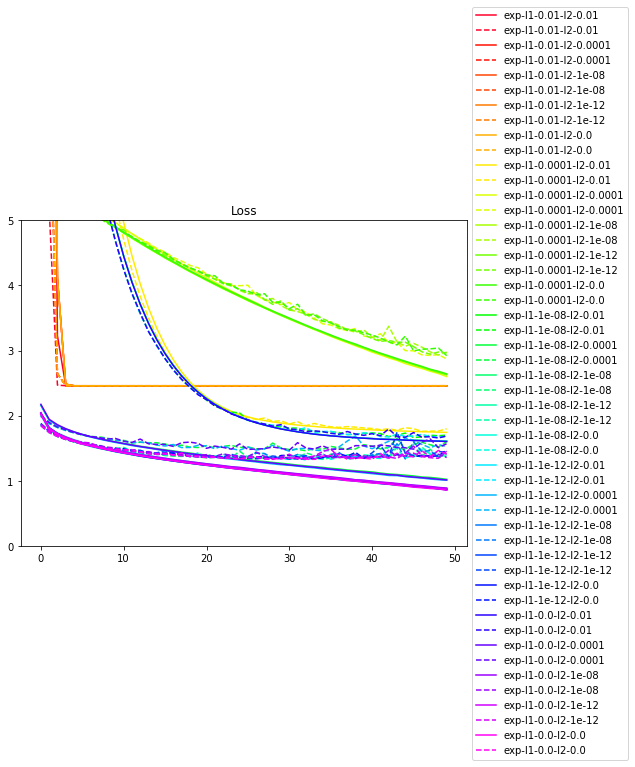

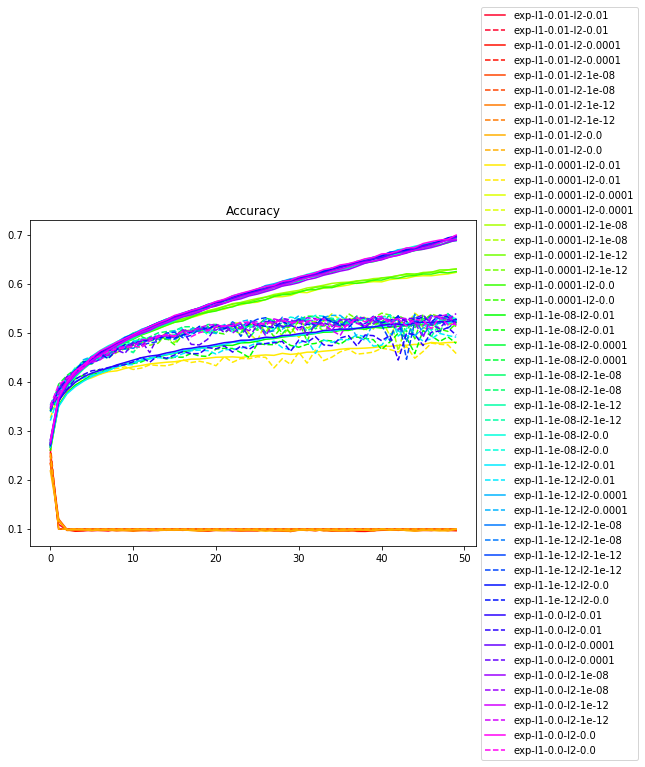

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()